<a href="https://colab.research.google.com/github/luyunghsiang/pytorchexamples/blob/main/function/houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import csv

In [2]:
def DataTransform(filepath):
  with open(filepath, mode ='r') as file:
    trainfile = csv.reader(file)
    firstrow = next(trainfile)
    inputdim = len(firstrow)
    factors = []
    prices = []
    for line in trainfile:
      inputs = line[0: inputdim - 1]
      output = line[inputdim - 1: inputdim]
      '''
      values = [eval(inputs[0])]
      values.append(eval(inputs[1]))
      values.append(1e-2 * eval(inputs[2]))
      values.append(1e-2 * eval(inputs[3]))
      values.append(1e-3 * eval(inputs[4]))
      '''
      values = [eval(i) for i in inputs] # convert list of strings to list of values
      normalize = [1, 1, 1e-2, 1e-2, 1e-3]
      values = np.multiply(values, normalize)
      factors.append(values)
      value = [1e-6 * eval(i) for i in output] # unit of price: million
      prices.append(value)
  torchfactors = torch.tensor(np.array(factors), dtype = torch.float32)
  torchprices = torch.tensor(np.array(prices), dtype = torch.float32)
  return inputdim, torchfactors, torchprices

In [26]:
# data from https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot
# divided into training (80%), validation (10%), test (10%)
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/My Drive/Colab Notebooks/machine learning/Functions/House Prices/"
# trainname = path + "training-small.csv"
trainname = path + "training.csv"
validname = path + "validation.csv"
testname = path + "test.csv"
traindim, trainfactors, trainprices = DataTransform(trainname)
validdim, validfactors, validprices = DataTransform(validname)
testdim,  testfactors,  testprices = DataTransform(testname)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
# draw histogram to check whether there any extreme value
pricelist = trainprices.view(-1, 1)
print(pricelist.shape)
print(max(pricelist), min(pricelist), len(pricelist))
import statistics
print(statistics.stdev(pricelist.view(-1)))
plt.hist(pricelist, 30)
plt.show()

torch.Size([5486, 1])
tensor([9.]) tensor([0.1310]) 5486


TypeError: can't convert type 'Tensor' to numerator/denominator

In [29]:
print(trainprices)

tensor([[1.3620],
        [1.4720],
        [0.7380],
        ...,
        [0.6900],
        [0.5000],
        [1.3020]])


In [37]:
print(pricelist)

tensor([[1.3620],
        [1.4720],
        [0.7380],
        ...,
        [0.6900],
        [0.5000],
        [1.3020]])


In [4]:
# factors = trainset[0:inputdim - 2, ]
# prices = trainset[inputdim - 1: inputdim - 1, ]
# print(factors)
# print(prices)

In [5]:
class HousePrice(nn.Module):
  def __init__(self, inputdim):
    super(HousePrice, self).__init__()
    self.degree = inputdim
    self.linear1 = torch.nn.Linear(self.degree, 8)
    self.linear2 = torch.nn.Linear(8, 8)
    self.linear3 = torch.nn.Linear(8, 1)
  def forward(self,x):
    x = self.linear1(x)
    x = torch.relu(x)
    x = self.linear2(x)
    x = torch.relu(x)
    x = self.linear3(x)
    # print("x = " + str(x))
    x = torch.abs(x)
    return x

In [6]:
def Train(model, input, output, learning_rate = 1e-6, loss_threshold = 1e-2, max_iterations = 1e+5):
  stop = False
  loss_list = []
  stop = False
  lossfunc = nn.MSELoss(reduction='sum')
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  iter = 0
  '''
  print("model")
  print(model.linear1.weight)
  print(model.linear2.weight)
  print(model.linear3.weight)
  print("____________________")
  print("input")
  print(input)
  print("output")
  print(output)
  print("====================")
  '''
  while ((stop == False) and (iter < max_iterations)):
    ybar = model(input)
    '''
    print("ybar")
    print(ybar)
    print("..................")
    '''
    optimizer.zero_grad()
    loss = lossfunc(ybar, output)
    '''
    print("loss")
    print(loss)
    print("~~~~~~~~~~~~~~~~~~~")
    '''
    if((iter % 1000) == 0):
      loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    '''
    print("model")
    print(model.linear1.weight)
    print(model.linear2.weight)
    print(model.linear3.weight)
    print("____________________")
    '''
    if (loss < loss_threshold):
      stop = True
    iter = iter + 1
  return iter, loss_list

In [7]:
pricemodel = HousePrice(traindim - 1)
'''
print(pricemodel.linear1.weight)
print(pricemodel.linear2.weight)
print(pricemodel.linear3.weight)
'''
iterations, loss_list = Train(pricemodel, trainfactors, trainprices, loss_threshold= 0.1)
'''
print(iterations)
print(pricemodel.linear1.weight)
print(pricemodel.linear2.weight)
print(pricemodel.linear3.weight)
'''

'\nprint(iterations)\nprint(pricemodel.linear1.weight)\nprint(pricemodel.linear2.weight)\nprint(pricemodel.linear3.weight)\n'

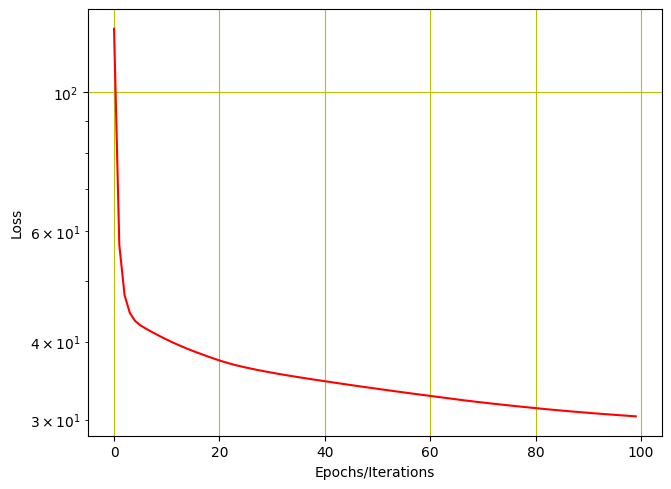

In [8]:
plt.plot(loss_list, 'r')
plt.tight_layout()
plt.grid('True', color='y')
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [17]:
# print(trainfactors)
sampletrainprices = trainprices[1:1000]
samplemodelprices = pricemodel(trainfactors)[1:1000]
# print(validfactors[1:10])
vprices = pricemodel(validfactors)
samplevalidmodel = validprices[1:100]
samplevalidprices = vprices[1:100]
'''
print(sampletrainprices)
print(samplemodelprices)
print(samplevalidprices)
print(samplevalidmodel)
'''

'\nprint(sampletrainprices)\nprint(samplemodelprices)\nprint(samplevalidprices)\nprint(samplevalidmodel)\n'

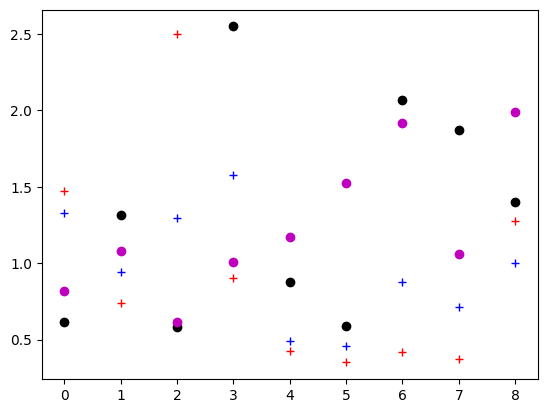

In [10]:
plt.plot(sampletrainprices, 'r+')
plt.plot(samplemodelprices.detach().numpy(), 'b+')
plt.plot(samplevalidmodel, 'ko')
plt.plot(samplevalidprices.detach().numpy(), 'mo')
plt.show()

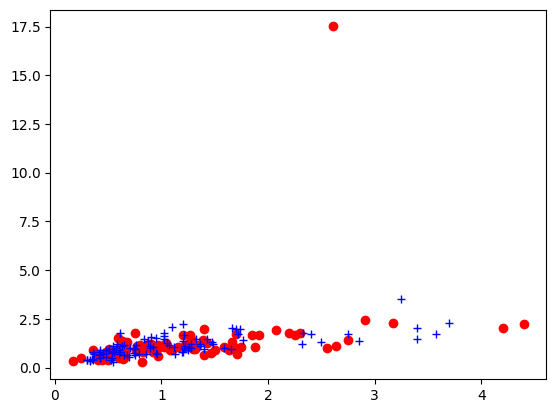

In [18]:
# x-y plot
plt.plot(samplevalidmodel, samplevalidprices.detach().numpy(), 'ro')
plt.plot(sampletrainprices, samplemodelprices.detach().numpy(), 'b+')
plt.show()

In [12]:
'''
with open(name, mode ='r') as file:
  trainfile = csv.reader(file)
  firstrow = next(trainfile)
  inputdim = len(firstrow)
  factors = []
  prices = []
  for line in trainfile:
    inputs = line[0: inputdim - 1]
    output = line[inputdim - 1: inputdim]
    # print(inputs)
    # print(output)
    values = [eval(i) for i in inputs] # convert list of strings to list of values
    factors.append(values)
    value = [1e-6 * eval(i) for i in output] # unit of price: million
    prices.append(value)
# print(firstrow)
# print(type(factors))
# print(factors[0])
# print(prices[0])
trainfactors = torch.tensor(np.array(factors), dtype = torch.float32)
trainprices = torch.tensor(np.array(prices), dtype = torch.float32)
# print(type(trainfactors))
'''

"\nwith open(name, mode ='r') as file:\n  trainfile = csv.reader(file)\n  firstrow = next(trainfile)\n  inputdim = len(firstrow)\n  factors = []\n  prices = []\n  for line in trainfile:\n    inputs = line[0: inputdim - 1]\n    output = line[inputdim - 1: inputdim]\n    # print(inputs)\n    # print(output)\n    values = [eval(i) for i in inputs] # convert list of strings to list of values\n    factors.append(values)\n    value = [1e-6 * eval(i) for i in output] # unit of price: million\n    prices.append(value)\n# print(firstrow)\n# print(type(factors))\n# print(factors[0])\n# print(prices[0])\ntrainfactors = torch.tensor(np.array(factors), dtype = torch.float32)\ntrainprices = torch.tensor(np.array(prices), dtype = torch.float32)\n# print(type(trainfactors))\n"